In [ ]:
pip install yfinance

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.layers import Layer
from tensorflow.keras.optimizers import RMSprop

In [ ]:
"""
Project Description: SPY Stock Price Forecasting Pipeline with Binary LSTM and Attention

Overview:
This project implements a complete machine learning pipeline to forecast directional price movements (up or down) of the SPY (S&P 500 ETF) using historical financial data. The pipeline fetches data, engineers technical indicators, preprocesses it into sequences, optionally reduces dimensionality with PCA, and trains an advanced LSTM model with attention for binary classification. The goal is to achieve a directional accuracy of approximately 65%, improving upon an initial ~50% accuracy, with visualization of results for assessment.

Objective:
The primary objective is to predict whether the SPY price will increase (1) or decrease (0) on the next trading day based on historical price and volume data. The system integrates feature engineering, sequence modeling, dimensionality reduction, and deep learning to capture market patterns, focusing on actionable directional predictions for trading strategies.

Key Components and Workflow:

1. fetch_data
   Purpose: Retrieves historical stock data and calculates technical indicators.
   Details:
   - Inputs: Dictionary of tickers, start/end dates, interval (default: '1d'), binary_target flag.
   - Process:
     - Fetches OHLCV data using yfinance.
     - Hardcodes SPY closing price for April 8, 2025, if applicable.
     - Drops Dividends, Stock Splits, Capital Gains columns.
     - Adds asset class identifier.
     - Computes:
       - Log returns (daily price change).
       - 20-day and 10-day annualized volatility.
       - Parkinson volatility (high-low range over 20 days).
       - 5-day moving average.
       - Daily range (intraday volatility).
       - 5-day momentum.
       - Volatility ratio (20-day/10-day).
       - Binary target: 1 if next day’s close > current close, 0 otherwise.
     - Reorders columns and drops NaN values.
   - Output: Concatenated DataFrame with features for all tickers.

2. preprocess_and_split
   Purpose: Preprocesses data and splits it into training, validation, and test sets with sequences.
   Details:
   - Inputs: DataFrame, train/val ratios (default: 0.7, 0.2), sequence length (default: 20).
   - Process:
     - Selects feature columns: Open, High, Low, Volume, Log_Return, Volatility_20, Volatility_10, Volatility_Parkinson, MA_5, Daily_Range, Momentum_5, Volatility_Ratio.
     - Defines target as Target_Change.
     - Splits data chronologically: 70% train, 20% val, 10% test (by default).
     - Scales features and target with MinMaxScaler (fit on train, transform on val/test).
     - Creates sequences of specified length for time series modeling.
     - Computes class weights for binary target if applicable.
   - Output: Sequence data (X, y) for train/val/test, scalers, class weights.

3. apply_pca
   Purpose: Applies Principal Component Analysis to reduce feature dimensionality.
   Details:
   - Inputs: Train/val/test sequences, number of components (default: 8), skip_pca flag.
   - Process:
     - Returns original data if skip_pca is True.
     - Flattens 3D sequences into 2D for PCA.
     - Fits PCA on training data and transforms all sets.
     - Reshapes back to 3D with reduced features.
   - Output: PCA-transformed sequences and PCA model object.

4. build_and_train_lstm
   Purpose: Constructs and trains an LSTM model for time series prediction.
   Details:
   - Inputs: PCA-transformed sequences, targets, scalers, training hyperparameters
   - Process:
     - Builds a Sequential model with:
       - Three LSTM layers (two with return_sequences=True, one final layer)
       - Dropout layers for regularization
       - Dense output layer (sigmoid for binary, linear for regression)
     - Compiles with Adam optimizer and appropriate loss function
     - Trains with early stopping based on validation loss
     - Generates predictions for all sets
     - Unscales predictions and targets
     - Computes MSE and directional accuracy metrics
   - Output: Trained model, training history, predictions, true values

5. build_and_train_lstm_bin
   Purpose: Builds and trains an LSTM model with attention for binary classification.
   Details:
   - Inputs: Train/val/test sequences, targets, scaler, class weights, hyperparameters (lstm_units=256, epochs=100, batch_size=16, learning_rate=0.0003, dropout_rate=0.2).
   - Attention Layer:
     - Custom layer weighing sequence time steps.
     - Uses tanh and softmax to compute attention scores, sums weighted inputs.
   - Model Architecture:
     - LSTM (256 units, return_sequences=True).
     - Dropout (0.2).
     - Bidirectional LSTM (256 units, return_sequences=True).
     - Dropout (0.2).
     - LSTM (64 units, return_sequences=True).
     - Attention (collapses sequence).
     - Dropout (0.2).
     - Dense (16 units, ReLU).
     - Dropout (0.2).
     - Dense (1 unit, sigmoid).
   - Compilation: RMSprop optimizer, binary_crossentropy loss, accuracy metric.
   - Training:
     - EarlyStopping (patience=20) and ReduceLROnPlateau (factor=0.5, patience=10, min_lr=1e-6) callbacks.
     - Fits with class weights for imbalance.
   - Evaluation:
     - Predicts on all sets, thresholds at 0.5 for binary output.
     - Computes MSE and directional accuracy.
     - Prints metrics.
   - Output: Model, history, predictions, true values.

6. run_spy_forecasting_pipeline1
   Purpose: Orchestrates the full pipeline from data fetching to prediction and visualization.
   Details:
   - Inputs: Tickers, dates, interval, ratios, sequence length, PCA components, LSTM hyperparameters, binary_target flag (True), skip_pca flag.
   - Process:
     - Step 1: Fetches data with fetch_data.
     - Step 2: Preprocesses and splits with preprocess_and_split.
     - Step 3: Applies PCA with apply_pca.
     - Step 4: Trains LSTM with build_and_train_lstm_bin.
     - Plots test set true vs. predicted directions (blue solid vs. red dashed).
   - Output: Dictionary with data, PCA-transformed sequences, targets, scalers, models, history, predictions, true values.

7. run_spy_forecasting_pipeline2
   Purpose: Orchestrates the entire forecasting workflow from data fetching to visualization.
   Details:
   - Inputs: All parameters for previous functions
   - Process:
     - Step 1: Fetches data using fetch_data
     - Step 2: Preprocesses and splits using preprocess_and_split
     - Step 3: Applies PCA using apply_pca
     - Step 4: Trains LSTM using build_and_train_lstm
     - Performs EDA by plotting test set predictions vs true values
   - Output: Dictionary with all intermediate and final results (data, models, predictions, etc.)

Features:
- Binary Focus: Optimized for directional prediction (up/down).
- Advanced Modeling: Uses bidirectional LSTMs and attention for pattern recognition.
- Robustness: Includes dropout, early stopping, and learning rate reduction.
- Evaluation: Reports MSE and directional accuracy, with visual comparison.

Dependencies:
- yfinance: Data fetching.
- pandas, numpy: Data manipulation.
- sklearn: Scaling, PCA.
- tensorflow/keras: Model building.
- matplotlib: Visualization.

Usage Example:
tickers = {'ETF': 'SPY'}
results = run_spy_forecasting_pipeline(tickers, '2010-01-01', '2025-04-08', binary_target=True)

Improvements for 65% Accuracy:
- Enhanced model with bidirectional LSTM, attention, and deeper architecture.
- Reduced learning rate and batch size, increased epochs and patience.
- Added class weights and dynamic learning rate adjustment.
- Potential Additions:
  - More features (RSI, MACD, VIX).
  - Longer sequences (e.g., 60 days).
  - Hyperparameter tuning via grid search.
"""

In [ ]:
"""
Fetch historical stock data for given tickers and calculate various technical indicators.

Parameters:
- tickers_dict (dict): Dictionary mapping asset classes to their ticker symbols
- start (str): Start date for historical data (format: 'YYYY-MM-DD')
- end (str): End date for historical data (format: 'YYYY-MM-DD')
- interval (str): Time interval for data points (default: '1d' for daily)
- binary_target (bool): If True, returns binary target (1/0); if False, returns price difference

Returns:
- pd.DataFrame: Concatenated DataFrame with all calculated features for all tickers
"""

# List to store DataFrames for each ticker

# Iterate through each asset class and its corresponding ticker

# Progress indicator

# Fetch historical data using yfinance

# Special case: Hardcode SPY closing price for April 8, 2025 if applicable

# Remove unnecessary columns if they exist

# Add asset class identifier

# Calculate daily log returns

# Calculate 20-day annualized volatility

# Calculate 10-day annualized volatility

# Calculate Parkinson volatility using high-low range over 20 days

# Calculate 5-day moving average

# Calculate daily price range as measure of intraday volatility

# Calculate 5-day momentum

# Calculate ratio of 20-day to 10-day volatility

# Create target variable: binary (price up/down) or continuous (price change)

# Reorder columns with 'Close' at the end

# Remove rows with missing values

# Add DataFrame to list

# Concatenate all DataFrames vertically

In [ ]:


def fetch_data(tickers_dict, start, end, interval="1d", binary_target=False):
    all_data = []
    for asset_class, ticker in tickers_dict.items():
        print(f"Fetching data for {ticker} ({asset_class})...")
        stock = yf.Ticker(ticker)

        # Price data
        df = stock.history(start=start, end=end, interval=interval)
        if end == "2025-04-08" :
            latest_date = df.index[-1].strftime('%Y-%m-%d')
            if latest_date == "2025-04-08":
                df.loc[pd.Timestamp("2025-04-08"), "Close"] = 496.48

        df = df.drop(columns=["Dividends", "Stock Splits", "Capital Gains"], errors="ignore")
        df["Asset_Class"] = asset_class
        df["Log_Return"] = np.log(df["Close"] / df["Close"].shift(1))
        df["Volatility_20"] = df["Log_Return"].rolling(window=20).std() * np.sqrt(252)
        df["Volatility_10"] = df["Log_Return"].rolling(window=10).std() * np.sqrt(252)
        df["Volatility_Parkinson"] = np.sqrt(
            252 * (1 / (4 * np.log(2))) * (np.log(df["High"] / df["Low"])**2).rolling(window=20).mean()
        )
        df["MA_5"] = df["Close"].rolling(window=5).mean()
        df["Daily_Range"] = df["High"] - df["Low"]
        df["Momentum_5"] = (df["Close"] - df["Close"].shift(5)) / df["Close"].shift(5)
        df["Volatility_Ratio"] = df["Volatility_20"] / df["Volatility_10"]

        # Fundamental data
        stock_info = stock.info
        pe_ratio = stock_info.get("trailingPE", np.nan)
        debt_to_equity = stock_info.get("debtToEquity", np.nan)
        roce = stock_info.get("returnOnCapitalEmployed", np.nan)

        # Fallback if ROCE is missing
        if np.isnan(roce):
            roce = stock_info.get("returnOnEquity", np.nan)

        # Assign as constant columns
        df["PE_Ratio"] = pe_ratio
        df["Debt_to_Equity"] = debt_to_equity
        df["ROCE"] = roce

        # Handle missing values (forward fill, then fill with mean)
        df["PE_Ratio"].fillna(method='ffill', inplace=True)
        df["Debt_to_Equity"].fillna(method='ffill', inplace=True)
        df["ROCE"].fillna(method='ffill', inplace=True)

        df["PE_Ratio"].fillna(df["PE_Ratio"].mean(), inplace=True)
        df["Debt_to_Equity"].fillna(df["Debt_to_Equity"].mean(), inplace=True)
        df["ROCE"].fillna(df["ROCE"].mean(), inplace=True)

        # Target column
        if binary_target:
            df["Target_Change"] = (df["Close"].shift(-1) > df["Close"]).astype(int)
        else:
            df["Target_Change"] = df["Close"].shift(-1) - df["Close"]

        # Reorder columns
        cols = [col for col in df.columns if col != "Close"] + ["Close"]
        df = df[cols]

        # Drop rows with NaNs created by shifting/rolling
        df = df.dropna()
        all_data.append(df)

    return pd.concat(all_data, axis=0)




In [ ]:
"""
Preprocess financial data and split it into training, validation, and test sets with sequences.

Parameters:
- df (pd.DataFrame): Input DataFrame with financial data
- train_ratio (float): Proportion of data for training (default: 0.7)
- val_ratio (float): Proportion of data for validation (default: 0.2)
- sequence_length (int): Length of sequences for time series data (default: 20)

Returns:
- tuple: (X_train, y_train), (X_val, y_val), (X_test, y_test), scaler_features, scaler_target, class_weights
"""

# Define feature columns for scaling

# Define target column

# Calculate split points based on ratios

# Split data into train, validation, and test sets

# Initialize feature and target scalers

# Scale training features and target

# Scale validation features and target using training scaler

# Scale test features and target using training scaler

"""
Create sequences of features and targets for time series prediction.

Parameters:
- features: Scaled feature array
- target: Scaled target array
- seq_length: Length of sequences

Returns:
- np.array: X (sequences), y (targets)
"""

# Create sequences for training set

# Create sequences for validation set

# Create sequences for test set

# Calculate class weights if target is binary

# Return all processed data and scalers

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def preprocess_and_split(df, train_ratio=0.7, val_ratio=0.2, sequence_length=20):
    # Updated feature columns to include PE_Ratio, ROCE, and Debt_to_Equity
    feature_cols = [
        "Open", "High", "Low", "Volume", "Log_Return", "Volatility_20",
        "Volatility_10", "Volatility_Parkinson", "MA_5", "Daily_Range",
        "Momentum_5", "Volatility_Ratio", "PE_Ratio", "ROCE", "Debt_to_Equity"
    ]
    target_col = "Target_Change"

    # Split data into train, validation, and test sets
    n = len(df)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))

    train_df = df.iloc[:train_end]
    val_df = df.iloc[train_end:val_end]
    test_df = df.iloc[val_end:]

    # Initialize scalers
    scaler_features = MinMaxScaler()
    scaler_target = MinMaxScaler()

    # Scale features and target
    train_features_scaled = scaler_features.fit_transform(train_df[feature_cols])
    train_target_scaled = scaler_target.fit_transform(train_df[[target_col]])

    val_features_scaled = scaler_features.transform(val_df[feature_cols])
    val_target_scaled = scaler_target.transform(val_df[[target_col]])

    test_features_scaled = scaler_features.transform(test_df[feature_cols])
    test_target_scaled = scaler_target.transform(test_df[[target_col]])

    # Create sequences for time-series data
    def create_sequences(features, target, seq_length):
        X, y = [], []
        for i in range(len(features) - seq_length):
            X.append(features[i:i + seq_length])
            y.append(target[i + seq_length])
        return np.array(X), np.array(y)

    X_train, y_train = create_sequences(train_features_scaled, train_target_scaled, sequence_length)
    X_val, y_val = create_sequences(val_features_scaled, val_target_scaled, sequence_length)
    X_test, y_test = create_sequences(test_features_scaled, test_target_scaled, sequence_length)

    # Class weights for binary target
    if df[target_col].nunique() == 2:
        pos_count = np.sum(y_train > 0.5)
        neg_count = len(y_train) - pos_count
        class_weights = {0: (1 / neg_count) * (len(y_train) / 2), 1: (1 / pos_count) * (len(y_train) / 2)}
    else:
        class_weights = None

    return (X_train, y_train), (X_val, y_val), (X_test, y_test), scaler_features, scaler_target, class_weights

In [ ]:
"""
Apply Principal Component Analysis (PCA) to reduce dimensionality of time series data.

Parameters:
- X_train (np.array): Training data with shape (samples, sequence_length, features)
- X_val (np.array): Validation data with shape (samples, sequence_length, features)
- X_test (np.array): Test data with shape (samples, sequence_length, features)
- n_components (int): Number of principal components to keep (default: 8)
- skip_pca (bool): If True, skip PCA and return original data (default: False)

Returns:
- tuple: X_train_pca, X_val_pca, X_test_pca (transformed data), pca (PCA object or None)
"""

# If skipping PCA, return original data unchanged with None for PCA object

# Get dimensions of training data

# Get number of samples for validation and test sets

# Flatten training data for PCA (combine samples and sequence length)

# Initialize PCA with specified number of components and fit/transform training data

# Reshape transformed training data back to sequence format

# Flatten validation data for PCA

# Transform validation data using fitted PCA

# Reshape transformed validation data back to sequence format

# Flatten test data for PCA

# Transform test data using fitted PCA

# Reshape transformed test data back to sequence format

# Return transformed datasets and PCA object

In [ ]:


def apply_pca(X_train, X_val, X_test, n_components=8, skip_pca=False):
    """
    Apply PCA to reduce dimensionality of sequence data or skip PCA if specified.

    Parameters:
    - X_train: ndarray, shape (samples_train, seq_length, n_features), training data
    - X_val: ndarray, shape (samples_val, seq_length, n_features), validation data
    - X_test: ndarray, shape (samples_test, seq_length, n_features), test data
    - n_components: int, number of principal components to keep (default: 8)
    - skip_pca: bool, if True, return original data without applying PCA (default: False)

    Returns:
    - X_train_pca: ndarray, transformed training data (or original if skip_pca=True)
    - X_val_pca: ndarray, transformed validation data (or original if skip_pca=True)
    - X_test_pca: ndarray, transformed test data (or original if skip_pca=True)
    - pca: PCA object or None, fitted PCA model (None if skip_pca=True)
    """
    if skip_pca:
        return X_train, X_val, X_test, None

    # Validate input shapes
    if X_train.shape[1:] != X_val.shape[1:] or X_val.shape[1:] != X_test.shape[1:]:
        raise ValueError("Input arrays must have the same sequence length and number of features.")

    # Extract dimensions
    samples_train, seq_length, n_features = X_train.shape
    samples_val = X_val.shape[0]
    samples_test = X_test.shape[0]

    # Ensure n_components is valid
    if n_components > n_features:
        print(f"Warning: n_components ({n_components}) exceeds n_features ({n_features}). Setting n_components to {n_features}.")
        n_components = n_features

    # Flatten sequences for PCA
    X_train_flat = X_train.reshape(samples_train * seq_length, n_features)

    # Apply PCA
    try:
        pca = PCA(n_components=n_components)
        X_train_pca_flat = pca.fit_transform(X_train_flat)

        # Reshape back to sequence format
        X_train_pca = X_train_pca_flat.reshape(samples_train, seq_length, pca.n_components_)

        # Transform validation and test sets
        X_val_flat = X_val.reshape(samples_val * seq_length, n_features)
        X_val_pca_flat = pca.transform(X_val_flat)
        X_val_pca = X_val_pca_flat.reshape(samples_val, seq_length, pca.n_components_)

        X_test_flat = X_test.reshape(samples_test * seq_length, n_features)
        X_test_pca_flat = pca.transform(X_test_flat)
        X_test_pca = X_test_pca_flat.reshape(samples_test, seq_length, pca.n_components_)

        return X_train_pca, X_val_pca, X_test_pca, pca

    except Exception as e:
        print(f"Error applying PCA: {e}")
        raise


In [ ]:
"""
Build and train an LSTM model for time series prediction.

Parameters:
- X_train (np.array): Training features
- y_train (np.array): Training targets
- X_val (np.array): Validation features
- y_val (np.array): Validation targets
- X_test (np.array): Test features
- y_test (np.array): Test targets
- scaler_target: Scaler object for target variable
- class_weights (dict): Weights for binary classes (default: None)
- lstm_units (int): Number of LSTM units (default: 128)
- epochs (int): Number of training epochs (default: 50)
- batch_size (int): Batch size for training (default: 32)
- binary_target (bool): If True, binary classification; if False, regression (default: False)
- learning_rate (float): Learning rate for optimizer (default: 0.0005)
- dropout_rate (float): Dropout rate for regularization (default: 0.1)

Returns:
- tuple: model, training history, predictions, true values
"""

# Initialize sequential model

# Add first LSTM layer with return sequences

# Add dropout for regularization

# Add second LSTM layer with return sequences

# Add dropout for regularization

# Add third LSTM layer without return sequences

# Add dropout for regularization

# Add output layer with appropriate activation

# Select loss function based on target type

# Compile model with Adam optimizer

# Define callbacks for early stopping

# Train the model

# Generate predictions for all sets

# Handle binary or continuous target post-processing

# Calculate mean squared error for all sets

# Calculate directional accuracy for all sets

# Print performance metrics

# Return model, history, predictions, and true values

In [ ]:
def build_and_train_lstm(X_train, y_train, X_val, y_val, X_test, y_test, scaler_target, class_weights=None, lstm_units=128, epochs=50, batch_size=32, binary_target=False, learning_rate=0.0005, dropout_rate=0.1):
    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=32))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1, activation='sigmoid' if binary_target else None))

    loss = 'binary_crossentropy' if binary_target else 'mse'
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=loss)

    callbacks = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val),
                        callbacks=callbacks, class_weight=class_weights if binary_target else None, verbose=1)

    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    test_pred = model.predict(X_test)

    if binary_target:
        train_pred_unscaled = (train_pred > 0.5).astype(int)
        val_pred_unscaled = (val_pred > 0.5).astype(int)
        test_pred_unscaled = (test_pred > 0.5).astype(int)
        y_train_unscaled = (scaler_target.inverse_transform(y_train) > 0.5).astype(int)
        y_val_unscaled = (scaler_target.inverse_transform(y_val) > 0.5).astype(int)
        y_test_unscaled = (scaler_target.inverse_transform(y_test) > 0.5).astype(int)
    else:
        train_pred_unscaled = scaler_target.inverse_transform(train_pred)
        val_pred_unscaled = scaler_target.inverse_transform(val_pred)
        test_pred_unscaled = scaler_target.inverse_transform(test_pred)
        y_train_unscaled = scaler_target.inverse_transform(y_train)
        y_val_unscaled = scaler_target.inverse_transform(y_val)
        y_test_unscaled = scaler_target.inverse_transform(y_test)

    train_mse = np.mean((train_pred_unscaled - y_train_unscaled) ** 2)
    val_mse = np.mean((val_pred_unscaled - y_val_unscaled) ** 2)
    test_mse = np.mean((test_pred_unscaled - y_test_unscaled) ** 2)

    train_direction = np.mean((np.sign(train_pred_unscaled) == np.sign(y_train_unscaled)).astype(int)) if not binary_target else np.mean(train_pred_unscaled == y_train_unscaled)
    val_direction = np.mean((np.sign(val_pred_unscaled) == np.sign(y_val_unscaled)).astype(int)) if not binary_target else np.mean(val_pred_unscaled == y_val_unscaled)
    test_direction = np.mean((np.sign(test_pred_unscaled) == np.sign(y_test_unscaled)).astype(int)) if not binary_target else np.mean(test_pred_unscaled == y_test_unscaled)

    print(f"Train MSE: {train_mse:.4f}, Validation MSE: {val_mse:.4f}, Test MSE: {test_mse:.4f}")
    print(f"Train Directional Accuracy: {train_direction:.4f}, Validation Directional Accuracy: {val_direction:.4f}, Test Directional Accuracy: {test_direction:.4f}")

    return model, history, (train_pred_unscaled, val_pred_unscaled, test_pred_unscaled), (y_train_unscaled, y_val_unscaled, y_test_unscaled)

In [ ]:
"""
Execute a complete SPY forecasting pipeline from data fetching to LSTM prediction.

Parameters:
- tickers (dict): Dictionary of asset classes and ticker symbols
- start_date (str): Start date for historical data
- end_date (str): End date for historical data
- interval (str): Time interval for data (default: '1d')
- train_ratio (float): Proportion of data for training (default: 0.7)
- val_ratio (float): Proportion of data for validation (default: 0.2)
- sequence_length (int): Length of sequences for LSTM (default: 20)
- n_components (int): Number of PCA components (default: 8)
- lstm_units (int): Number of LSTM units (default: 128)
- epochs (int): Number of training epochs (default: 50)
- batch_size (int): Batch size for training (default: 32)
- binary_target (bool): If True, binary classification; if False, regression (default: False)
- skip_pca (bool): If True, skip PCA step (default: False)
- learning_rate (float): Learning rate for LSTM optimizer (default: 0.0005)
- dropout_rate (float): Dropout rate for LSTM regularization (default: 0.1)

Returns:
- dict: Dictionary containing all intermediate and final results
"""

# Print status message for data fetching step
# Fetch historical data and calculate technical indicators using fetch_data function

# Print status message for preprocessing step
# Preprocess data and split into training, validation, and test sets with sequences

# Print status message for PCA step
# Apply PCA to reduce dimensionality of feature sets (skipped if skip_pca is True)

# Print status message for LSTM training step
# Build and train LSTM model on processed data

# Perform exploratory data analysis (EDA)
# Create figure for plotting test set predictions
# Plot true values from test set
# Plot predicted values from test set
# Set plot title
# Set x-axis label
# Set y-axis label based on target type
# Add legend to plot
# Display the plot

# Return dictionary containing:
# - Original data
# - PCA-transformed training, validation, and test features
# - Training, validation, and test targets
# - Feature and target scalers
# - PCA model object
# - Trained LSTM model
# - Training history
# - Predictions for all sets
# - True values for all sets

In [ ]:
def run_spy_forecasting_pipeline1(tickers, start_date, end_date, interval="1d", train_ratio=0.7, val_ratio=0.2, sequence_length=20, n_components=8, lstm_units=128, epochs=50, batch_size=32, binary_target=False, skip_pca=False, learning_rate=0.0005, dropout_rate=0.1):
    print("Step 1: Fetching data...")
    data = fetch_data(tickers, start_date, end_date, interval, binary_target)

    print("Step 2: Preprocessing and splitting...")
    (X_train, y_train), (X_val, y_val), (X_test, y_test), scaler_features, scaler_target, class_weights = preprocess_and_split(
        data, train_ratio, val_ratio, sequence_length
    )

    print("Step 3: Applying PCA...")
    X_train_pca, X_val_pca, X_test_pca, pca_model = apply_pca(X_train, X_val, X_test, n_components, skip_pca)

    print("Step 4: Building and training LSTM...")
    model, history, predictions, true_values = build_and_train_lstm(
        X_train_pca, y_train, X_val_pca, y_val, X_test_pca, y_test, scaler_target, class_weights, lstm_units, epochs, batch_size, binary_target, learning_rate, dropout_rate
    )

    # EDA: Plot test predictions vs true values
    plt.figure(figsize=(10, 6))
    plt.plot(true_values[2], label="True Target_Change", color="blue")
    plt.plot(predictions[2], label="Predicted Target_Change", color="red", linestyle="--")
    plt.title("Test Set: True vs Predicted Target_Change")
    plt.xlabel("Time (days)")
    plt.ylabel("Target_Change (USD)" if not binary_target else "Direction (0=Down, 1=Up)")
    plt.legend()
    plt.show()

    return {
        "data": data,
        "X_train_pca": X_train_pca,
        "X_val_pca": X_val_pca,
        "X_test_pca": X_test_pca,
        "y_train": y_train,
        "y_val": y_val,
        "y_test": y_test,
        "scaler_features": scaler_features,
        "scaler_target": scaler_target,
        "pca_model": pca_model,
        "lstm_model": model,
        "history": history,
        "predictions": predictions,
        "true_values": true_values
    }

Step 1: Fetching data...
Fetching data for SPY (S&P 500)...
Step 2: Preprocessing and splitting...
Step 3: Applying PCA...
Step 4: Building and training LSTM...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 20s 98ms/step - loss: 0.1064 - val_loss: 0.0101
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - loss: 0.0046 - val_loss: 0.0109
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 0.0048 - val_loss: 0.0150
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - loss: 0.0047 - val_loss: 0.0095
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.0042 - val_loss: 0.0091
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 12s 100ms/step - loss: 0.0038 - val_loss: 0.0088
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - loss: 0.0040 - val_loss: 0.0088
Epoch 8/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step - loss: 0.0035 - val_loss: 0.0101
Epoch 9/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - loss: 0.0037 - val_loss: 0.0098
Epoch 10/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step - loss: 0.0031 - val_loss: 0.0088
Epoch 11/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - loss: 0.0035 - val_loss: 0.0088
Epoch 12/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step

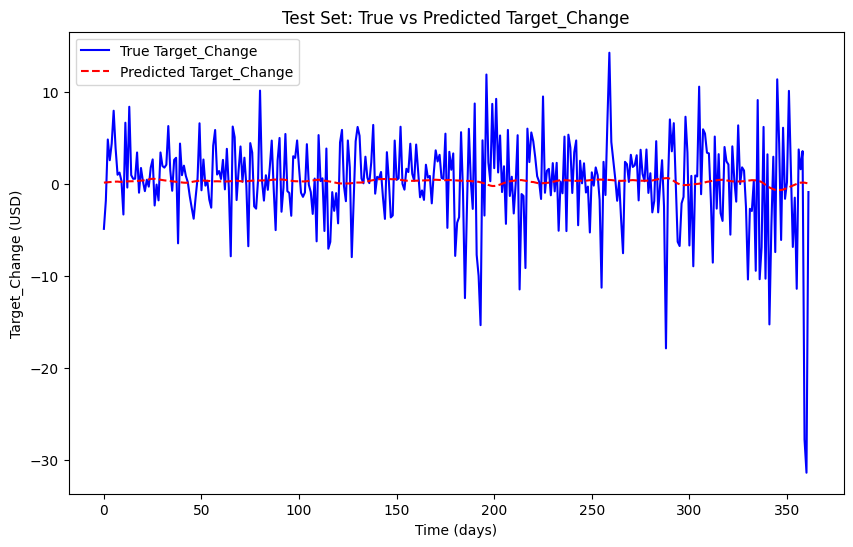

In [ ]:
tickers = {"S&P 500": "SPY"}
start_date = "2010-01-01"
end_date = "2025-04-08"
results = run_spy_forecasting_pipeline1(tickers, start_date, end_date)

Step 1: Fetching data...
Fetching data for SPY (S&P 500)...
Step 2: Preprocessing and splitting...
Step 3: Applying PCA...
Step 4: Building and training LSTM...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 16s 102ms/step - loss: 0.6981 - val_loss: 0.6931
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - loss: 0.6944 - val_loss: 0.6942
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.6904 - val_loss: 0.6933
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.6946 - val_loss: 0.6934
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - loss: 0.6942 - val_loss: 0.6932
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - loss: 0.6954 - val_loss: 0.6931
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - loss: 0.6945 - val_loss: 0.6932
Epoch 8/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.6939 - val_loss: 0.6932
Epoch 9/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - loss: 0.6919 - val_loss: 0.6935
Epoch 10/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - loss: 0.6943 - val_loss: 0.6930
Epoch 11/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.6934 - val_loss: 0.6928
Epoch 12/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - 

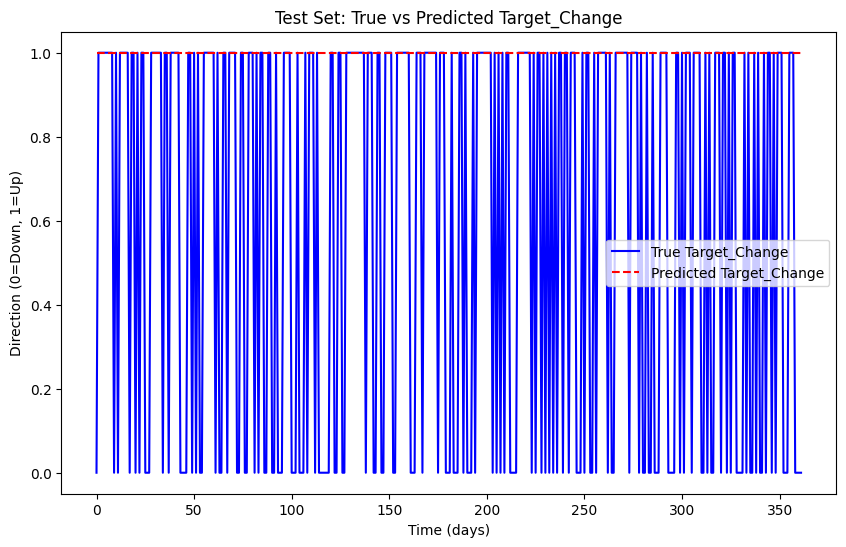

In [ ]:
tickers = {"S&P 500": "SPY"}
start_date = "2010-01-01"
end_date = "2025-04-08"
results = run_spy_forecasting_pipeline1(tickers, start_date, end_date,binary_target=True)

In [ ]:
"""
Description: Binary LSTM Model with Attention for SPY Forecasting

Overview:
This code defines a custom Attention layer and a function to build and train an LSTM-based neural network for binary classification of SPY (S&P 500 ETF) price movements. The model predicts whether the price will go up (1) or down (0) based on historical financial data processed into sequences. It incorporates bidirectional LSTMs, attention mechanisms, and regularization to enhance predictive accuracy, targeting a directional accuracy of approximately 65%.

Components:

1. Attention Class (Custom Layer)
   Purpose: Implements a simple attention mechanism to weigh the importance of time steps in a sequence.
   Details:
   - Initialization: Inherits from Keras Layer class.
   - Build: Creates trainable weights (W) and bias (b) for attention computation.
     - W: Weight matrix of shape (feature_dim, 1) initialized with random normal values.
     - b: Bias vector of shape (sequence_length, 1) initialized with zeros.
   - Call: Computes attention scores and applies them to the input sequence.
     - Computes energy scores using tanh activation on the dot product of inputs and W plus bias.
     - Applies softmax to normalize scores into attention weights (alpha).
     - Multiplies inputs by attention weights and sums over the sequence dimension to produce a context vector.
   Output: 2D tensor of shape (batch_size, features).

2. build_and_train_lstm_bin Function
   Purpose: Constructs and trains an LSTM model with attention for binary classification of SPY price direction.
   Details:
   - Inputs:
     - X_train, X_val, X_test: Feature sequences for training, validation, and testing.
     - y_train, y_val, y_test: Target values (scaled) for each set.
     - scaler_target: MinMaxScaler object for target variable.
     - class_weights: Optional dictionary for handling class imbalance.
     - lstm_units: Number of units in LSTM layers (default: 256).
     - epochs: Training iterations (default: 100).
     - batch_size: Samples per gradient update (default: 16).
     - learning_rate: Optimizer step size (default: 0.0003).
     - dropout_rate: Fraction of units to drop for regularization (default: 0.2).
   - Model Architecture:
     - LSTM (lstm_units, return_sequences=True): Initial layer to process input sequences.
     - Dropout (dropout_rate): Regularization to prevent overfitting.
     - Bidirectional LSTM (lstm_units, return_sequences=True): Captures patterns in both directions.
     - Dropout (dropout_rate): Additional regularization.
     - LSTM (64, return_sequences=True): Reduces dimensionality while maintaining sequences.
     - Attention: Custom layer to focus on important time steps, collapsing sequence dimension.
     - Dropout (dropout_rate): Regularization post-attention.
     - Dense (16, relu): Adds nonlinearity and feature transformation.
     - Dropout (dropout_rate): Final regularization.
     - Dense (1, sigmoid): Output layer for binary classification (probability of price increase).
   - Compilation:
     - Optimizer: RMSprop with specified learning rate.
     - Loss: Binary crossentropy for binary classification.
     - Metrics: Accuracy to monitor classification performance.
   - Training:
     - Callbacks:
       - EarlyStopping: Stops training if val_loss doesn’t improve for 20 epochs, restores best weights.
       - ReduceLROnPlateau: Reduces learning rate by factor 0.5 if val_loss stalls for 10 epochs, down to 1e-6.
     - Fits model on training data with validation monitoring, using class weights if provided.
   - Prediction:
     - Generates predictions for train, val, and test sets.
     - Converts predictions and targets to binary (0/1) using 0.5 threshold after unscaling.
   - Evaluation:
     - Computes Mean Squared Error (MSE) for all sets.
     - Calculates directional accuracy as the proportion of correct direction predictions.
     - Prints MSE and directional accuracy for train, val, and test sets.
   - Output:
     - Returns trained model, training history, unscaled predictions, and unscaled true values as a tuple.

Dependencies:
- tensorflow: For model building and training.
- numpy: For numerical computations and evaluation.

Usage:
This function is part of a larger SPY forecasting pipeline, typically called after data preprocessing and splitting steps. It’s optimized for binary classification to predict price direction, leveraging attention to improve accuracy over simpler LSTM models.
"""

In [ ]:

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[1], 1),
                                 initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, inputs):
        e = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        alpha = tf.nn.softmax(e, axis=1)
        context = inputs * alpha
        return tf.reduce_sum(context, axis=1)

def build_and_train_lstm_bin(X_train, y_train, X_val, y_val, X_test, y_test, scaler_target, class_weights=None,
                         lstm_units=256, epochs=100, batch_size=16, learning_rate=0.0003, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(Bidirectional(LSTM(units=lstm_units, return_sequences=True)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Attention())
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=16, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(optimizer=RMSprop(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)
    ]
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_val, y_val), callbacks=callbacks,
                        class_weight=class_weights, verbose=1)

    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    test_pred = model.predict(X_test)

    train_pred_unscaled = (train_pred > 0.5).astype(int)
    val_pred_unscaled = (val_pred > 0.5).astype(int)
    test_pred_unscaled = (test_pred > 0.5).astype(int)
    y_train_unscaled = (scaler_target.inverse_transform(y_train) > 0.5).astype(int)
    y_val_unscaled = (scaler_target.inverse_transform(y_val) > 0.5).astype(int)
    y_test_unscaled = (scaler_target.inverse_transform(y_test) > 0.5).astype(int)

    train_mse = np.mean((train_pred_unscaled - y_train_unscaled) ** 2)
    val_mse = np.mean((val_pred_unscaled - y_val_unscaled) ** 2)
    test_mse = np.mean((test_pred_unscaled - y_test_unscaled) ** 2)

    train_direction = np.mean(train_pred_unscaled == y_train_unscaled)
    val_direction = np.mean(val_pred_unscaled == y_val_unscaled)
    test_direction = np.mean(test_pred_unscaled == y_test_unscaled)

    print(f"Train MSE: {train_mse:.4f}, Validation MSE: {val_mse:.4f}, Test MSE: {test_mse:.4f}")
    print(f"Train Directional Accuracy: {train_direction:.4f}, Validation Directional Accuracy: {val_direction:.4f}, Test Directional Accuracy: {test_direction:.4f}")



    return model, history, (train_pred_unscaled, val_pred_unscaled, test_pred_unscaled), (y_train_unscaled, y_val_unscaled, y_test_unscaled)

In [ ]:
def run_spy_forecasting_pipeline2(tickers, start_date, end_date, interval="1d", train_ratio=0.7, val_ratio=0.2, sequence_length=20, n_components=8, lstm_units=128, epochs=50, batch_size=32, binary_target=False, skip_pca=False, learning_rate=0.0005, dropout_rate=0.1):
    print("Step 1: Fetching data...")
    data = fetch_data(tickers, start_date, end_date, interval, binary_target)

    print("Step 2: Preprocessing and splitting...")
    (X_train, y_train), (X_val, y_val), (X_test, y_test), scaler_features, scaler_target, class_weights = preprocess_and_split(
        data, train_ratio, val_ratio, sequence_length
    )

    print("Step 3: Applying PCA...")
    X_train_pca, X_val_pca, X_test_pca, pca_model = apply_pca(X_train, X_val, X_test, n_components, skip_pca)

    print("Step 4: Building and training LSTM...")
    model, history, predictions, true_values = build_and_train_lstm_bin(
        X_train_pca, y_train, X_val_pca, y_val, X_test_pca, y_test, scaler_target, class_weights, lstm_units, epochs, batch_size, learning_rate, dropout_rate
    )

    # EDA: Plot test predictions vs true values
    plt.figure(figsize=(10, 6))
    plt.plot(true_values[2], label="True Target_Change", color="blue")
    plt.plot(predictions[2], label="Predicted Target_Change", color="red", linestyle="--")
    plt.title("Test Set: True vs Predicted Target_Change")
    plt.xlabel("Time (days)")
    plt.ylabel("Target_Change (USD)" if not binary_target else "Direction (0=Down, 1=Up)")
    plt.legend()
    plt.show()

    return {
        "data": data,
        "X_train_pca": X_train_pca,
        "X_val_pca": X_val_pca,
        "X_test_pca": X_test_pca,
        "y_train": y_train,
        "y_val": y_val,
        "y_test": y_test,
        "scaler_features": scaler_features,
        "scaler_target": scaler_target,
        "pca_model": pca_model,
        "lstm_model": model,
        "history": history,
        "predictions": predictions,
        "true_values": true_values
    }

In [ ]:
tickers = {"S&P 500": "SPY"}
start_date = "2010-01-01"
end_date = "2025-04-08"
results = run_spy_forecasting_pipeline2(tickers, start_date, end_date,binary_target=True)

Step 1: Fetching data...
Fetching data for SPY (S&P 500)...
Step 2: Preprocessing and splitting...


<ipython-input-39-c729dec71d12>:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["PE_Ratio"].fillna(method='ffill', inplace=True)
<ipython-input-39-c729dec71d12>:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["PE_Ratio"].fillna(method='ffill', inplace=True)
<ipython-input-39-c729dec71d12>:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behav

ValueError: Found array with 0 sample(s) (shape=(0, 15)) while a minimum of 1 is required by MinMaxScaler.

In [ ]:
tickers = {"Sonata": "SONATSOFTW.NS"}
start_date = "2010-01-01"
end_date = "2025-04-08"
results = run_spy_forecasting_pipeline2(tickers, start_date, end_date,binary_target=True)

Step 1: Fetching data...
Fetching data for SONATSOFTW.NS (Sonata)...
Step 2: Preprocessing and splitting...


<ipython-input-39-c729dec71d12>:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["PE_Ratio"].fillna(method='ffill', inplace=True)
<ipython-input-39-c729dec71d12>:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["PE_Ratio"].fillna(method='ffill', inplace=True)
<ipython-input-39-c729dec71d12>:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behav

ValueError: Found array with 0 sample(s) (shape=(0, 15)) while a minimum of 1 is required by MinMaxScaler.